### week3

# Linear Regression

- regression examples
- Gaussian (Normal) distribution
- likelihood and maximum likelihood estimate
- coordinate descent
- multivariate regression

In [1]:
import pods
import notebook as nb
import mlai
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

### Review and Preview

- Last week we minimised a sum of squares objective function (ie, least squares) by (steepest) gradient descent and stochastic gradient descent algorithms

- This week we explore least squares for univariate and multivariate regression

### Regression Analysis

- statistical process for estimating the relationships among variables
- predict a real value, $y_i$, given some input $x_i$

Wikipedia: [Regression analysis](https://en.wikipedia.org/wiki/Regression_analysis)

### Olympic 100m

Wikimedia commons: [London 2012 Olympic 100m final start](http://bit.ly/191adDC)

Using regression we want to predict a winning time for the next Olympic game.

- graph showing gold medal times since 1896 (unit: seconds)

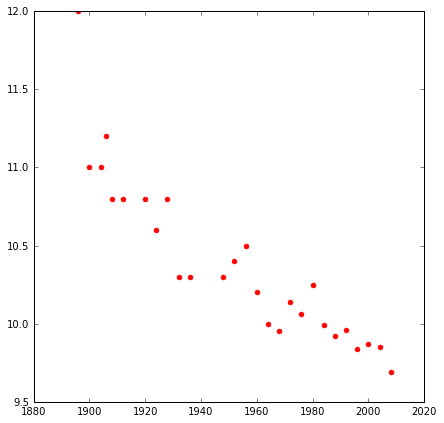

In [2]:
data = pods.datasets.olympic_100m_men()
f, ax = plt.subplots(figsize=(7,7))
ax.plot(data['X'], data['Y'], 'r.', markersize=10)

### Olympic Marathon

Wikimedia commons: [Stephen Kiprotich at the London 2012 men's Olympic marathon](http://bit.ly/16kMKHQ)

Using regression we want to predict a winning time for the next Olympic game.

- graph showing gold medal times since 1896 (unit: min per km)
- didn’t have a standardised distance before 1924
- badly organised in 1904 leading to very slow times

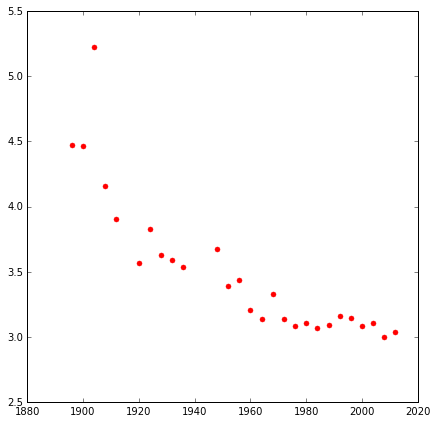

In [3]:
data = pods.datasets.olympic_marathon_men()
f, ax = plt.subplots(figsize=(7,7))
ax.plot(data['X'], data['Y'], 'r.',markersize=10)

### More Examples for Regression

- predict quality of meat given spectral measurements (eg, Tecator Data)
- radiocarbon dating, the C14 calibration curve: predict age given quantity of C14 isotope
- predict quality of different Go or Backgammon moves given expert rated training data

### Linear Regression

$$y_i = m x_i + c$$

Olympic example:

- $y_i$ : winning time
- $x_i$ : year of Olympics
- $m$ : rate of improvement over time
- $c$ : winning time at year 0

Wikipedia: [Linear regression](https://en.wikipedia.org/wiki/Linear_regression)

### Overdetermined and Underdetermined Systems

Each unknown can be seen as an available degree of freedom, while each equation constrains the system, restricting one degree of freedom.

##### Overdetermined system:

- the system has been overconstrained
- there are more equations than unknowns

##### Underdetermined system:

- the system has been underconstrained
- the number of equations is fewer than the number of unknowns

### Overdetermined System

$$y = mx + c$$

point 1: $x = 1$, $y=3$
$$3 = m + c$$

point 2: $x = 3$, $y=1$
$$1 = 3m + c$$

point 3: $x = 2$, $y=2.5$
$$2.5 = 2m + c$$

<img src="./figs/overdetermined.svg", width=700, align=center>

### Overdetermined System

Introduction of a **slack variable** $\epsilon$ :
$$y = mx + c + \epsilon$$

point 1: $x = 1$, $y=3$
$$3 = m + c + \epsilon_1$$

point 2: $x = 3$, $y=1$
$$1 = 3m + c + \epsilon_2$$

point 3: $x = 2$, $y=2.5$ 
$$2.5 = 2m + c + \epsilon_3$$

### Review: Gaussian (Normal) Distribution

$$
  p(y | \mu,\sigma^2) \buildrel\triangle\over = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(y - \mu)^2}{2\sigma^2} \right)
$$
- denote this distribution as
$$y \sim \mathcal{N}(\mu,\sigma^2)$$
- $\mu$ is the mean and $\sigma^2$ is the variance
- perhaps the most common/important probability distrution

Wikipedia: [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution)

### Two Important Gaussian Properties

**(1) Sum of Gaussians**

The sum of Gaussian variables is also Gaussian.

- suppose that $y_i \sim \mathcal{N}(\mu_i, \sigma_i^2)$, the sum is distributed as
$$\sum_{i=1}^n y_i \sim \mathcal{N}\left(\sum_{i=1}^n \mu_i, \sum_{i=1}^n \sigma_i^2\right)$$

(note) **central limit theorem**

As sum increases, sum of non Gaussian, finite variance variables is also Gaussian.

Wikipedia: [Central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)

### Two Important Gaussian Properties

**(2) Scaling a Gaussian**

Scaling a Gaussian leads to a Gaussian.

- suppose that $y \sim \mathcal{N}(\mu, \sigma^2)$, the scaled (by $w$) density is distributed as
$$wy \sim \mathcal{N}(w\mu, w^2\sigma^2)$$

### Laplace's Idea

Set the mean of Gaussian to be a function:
$$
  p(y_i|x_i) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(y_i-f(x_i))^2}{2\sigma^2} \right)
$$
This gives us a *noisy function*.

- known as a stochastic process

Wikipedia: [Pierre-Simon Laplace](https://en.wikipedia.org/wiki/Pierre-Simon_Laplace)

### Laplace's Idea

- the standard Gaussian is parametised by mean and variance
- make the mean a linear function of an *input*

This leads to a regression model:
$$
  y_i = f(x_i) + \epsilon_i = mx_i + c + \epsilon_i
$$
where $\epsilon_i \sim \mathcal{N}(0,\sigma^2)$.

- assume $y_i$ is height and $x_i$ is weight, ie, height is a function of weight

### Likelihood

The likelihood of parameter values $\theta$ given data $\mathbf{x}$ is the probability for those observed data given those parameter values:
$$
  \mathcal{L}(\theta|x) = p(x|\theta)
$$

Wikipedia: [Likelihood function](https://en.wikipedia.org/wiki/Likelihood_function)

### Data Point Likelihood

Likelihood of an individual data point $(x_i,y_i)$:
$$
  p(y_i | x_i,m,c,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(y_i-mx_i-c)^2}{2\sigma^2} \right)
$$

- parameters are gradient, $m$, offset, $c$, of the function and noise variance $\sigma^2$

### Data Set Likelihood

Likelihood for a data set $(\mathbf{x},\mathbf{y})$:
$$
  p(\mathbf{y} | \mathbf{x},m,c,\sigma^2) = \prod_{i=1}^n p(y_i | x_i,m,c,\sigma^2)
$$
for independent variables, ie, assume that

- the noise, $\epsilon_i$ is sampled independently for each data point
- given $m$ and $c$, each data point is independent

(note) **independent and identically distributed (i.i.d.) random variables**

Imagine a set of data where each data point (random variable) is independently drawn from the same distribution.

- each random variable has the same distribution as others
- they would be mutually independent

Wikipedia: [Independent and identically distributed random variables](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)

### Likelihood

A data set likelihood for **Normally distributed** random variables with the **i.i.d.** assumption:
\begin{align*}
  p(\mathbf{y} | \mathbf{x},m,c,\sigma^2)
  & = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(y_i-mx_i-c)^2}{2\sigma^2} \right) \\
  & = \frac{1}{\left(2\pi\sigma^2\right)^{\frac{n}{2}}} \exp\left( -\frac{\sum_{i=1}^n (y_i-mx_i-c)^2}{2\sigma^2} \right)
\end{align*}

### Log Likelihood

Often simpler if we work with the log likelihood:
\begin{align*}
  \mathcal{L}(m,c,\sigma^{2})
  & \buildrel\triangle\over = \log p(\mathbf{y} | \mathbf{x},m,c,\sigma^2) \\
  & = -\frac{n}{2}\log 2\pi - \frac{n}{2}\log\sigma^2 - \sum_{i=1}^n \frac{(y_i-mx_i-c)^2}{2\sigma^2}
\end{align*}

Wikipedia: [Likelihood function](https://en.wikipedia.org/wiki/Likelihood_function)

### Maximum Likelihood Estimation

The aim of maximum likelihood estimation is to find the parameter values $\theta$ that makes the observed data $\mathbf{x}$ most likely:
$$
  \mathop{\rm argmax}_{\theta} \mathcal{L}(\theta|x) = \mathop{\rm argmax}_{\theta} p(x|\theta)
$$

Wikipedia: [Maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)

### Consistency of Maximum Likelihood

Mainstay of classical statistics:

- If data was really generated according to probability we specified, correct parameters will be recovered in limit as $n \rightarrow \infty$.

- This can be proven through sample based approximations (law of large numbers) of *KL divergences*.

Wikipedia: [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)

(note) **law of large numbers**

The number of i.i.d. random variables increases, their sample mean approaches their theoretical mean.

(In other words, the number of trials increases, the outcomes will converge on the expected value.)

Wikipedia: [Law of large numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers)

### Error Function

Define an error function (objective function):
$$
  E(m,c,\sigma^{2}) = \frac{n}{2} \log\sigma^2 + \sum_{i=1}^n \frac{(y_i-mx_i-c)^2}{2\sigma^2}
$$

*Learning* proceeds by minimising this error function for the data set provided.

### Error Function

Probabilistic interpretation for minimising error function is equivalent to maximum likelihood with respect to parameters.

$$
  \mathcal{L}(m,c,\sigma^{2}) = \underbrace{-\frac{n}{2}\log 2\pi}_{constant} - E(m,c,\sigma^{2})
$$

- minimising error function is equivalent to maximising log likelihood
- maximising log likelihood is equivalent to maximising the likelihood because the logarithm is monotonic function

### Sum of Squares Error

Ignoring terms which don't depend on $m$ and $c$ gives
$$
  E(m,c) = \sum_{i=1}^n (y_i - f(x_i))^2
$$
where $f(x_i) = mx_i + c$.

This is known as the **sum of squares** error function.

- commonly used and is closely associated with the Gaussian likelihood

### Mathematical interpretation

Error function expresses mismatch between prediction and reality:
$$
  E(m,c) = \sum_{i=1}^n (y_i - f(x_i))^2
$$

Two functions are involved:

- prediction function: $f(x_i) = mx_i + c$
- error, or objective, function: $E(m,c)$

Error function depends on parameters, $m$ and $c$, through prediction function.

### Learning is Optimization

Learning is minimisation of the objective function.

- at the minima the gradient is zero

**Coordinate descent**: find gradient in each coordinate and set to zero.

Wikipedia: [Coordinate descent](https://en.wikipedia.org/wiki/Coordinate_descent)

### Learning is Optimization

The gradient of $E(m,c)$ along the offset $c$:
$$
  \frac{\partial E(m,c)}{\partial c} = -2\sum_{i=1}^n (y_i - mx_i - c)
$$
then set $\frac{\partial E(m,c)}{\partial c} = 0$, resulting in
$$
  c^* = \frac{\sum_{i=1}^n (y_i - mx_i)}{n}
$$

### Learning is Optimization

The gradient of $E(m,c)$ along the slope $m$:
$$
  \frac{\partial E(m,c)}{\partial m} = -2\sum_{i=1}^n x_i(y_i - mx_i - c)
$$
then set $\frac{\partial E(m,c)}{\partial m} = 0$, resulting in
$$
  m^* = \frac{\sum_{i=1}^n x_i(y_i - c)}{\sum_{i=1}^n x_i^2}
$$

### Fixed Point Updates

\begin{align*}
  c^* = & \frac{1}{n}\sum_{i=1}^n (y_i - mx_i) \\
  m^* = & \frac{\sum_{i=1}^n x_i(y_i - c^*)}{\sum_{i=1}^n x_i^2} \\
  (\sigma^2)^* = & \frac{1}{n} \sum_{i=1}^n (y_i - m^* x_i - c^*)^2
\end{align*}

### Multi-dimensional Inputs

There might be multiple factors that could contribute the outcome.
Place these factors in a feature vector $\mathbf{x}_i$ :
$$
  \mathbf{x}_i = \left( \begin{array}{c} x_{i1} \\ \vdots \\ x_{ip} \end{array} \right)
$$

Linear function is now defined as
$$
f(\mathbf{x}_i) = \sum_{j=1}^p w_j x_{ij} + c
$$

### Vector Notation

Now define a weight vector $\mathbf{w}$ :
$$
  \mathbf{w} = \left( \begin{array}{c} w_1 \\ \vdots \\ w_p \end{array} \right)
$$
so that we write linear function in vector notation:
$$
  f(\mathbf{x}_i) = \mathbf{w}^\top \mathbf{x}_i + c
$$

### Vector Notation

Can absorb $c$ into $\mathbf{w}$ by assuming extra input $x_0$ which is always 1, ie,
$$
  f(\mathbf{x}_i) = \mathbf{w}^\top \mathbf{x}_i
$$
where
$$
  \qquad
  \mathbf{w} = \left( \begin{array}{c} c \\ w_1 \\ \vdots \\ w_p \end{array} \right) \ ,
  \qquad
  \mathbf{x}_i = \left( \begin{array}{c} 1 \\ x_{i1} \\ \vdots \\ x_{ip} \end{array} \right)
$$

### Multivariate Regression: Likelihood

Likelihood of a single **data point**:
$$
  p(y_i | \mathbf{x}_i) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(y_i - \mathbf{w}^\top \mathbf{x}_i)^2}{2\sigma^2} \right)
$$

Log likelihood for a **data set**:
\begin{align*}
  \mathcal{L}(\mathbf{w},\sigma^2) = & \log\prod_{i=1}^n p(y_i | \mathbf{x}_i) \\
  = & - \frac{n}{2}\log 2\pi - \frac{n}{2}\log\sigma^2 - \sum_{i=1}^n \frac{(y_i - \mathbf{w}^\top \mathbf{x}_i)^2}{2\sigma^2}
\end{align*}

### Multivariate Regression: Error Function

\begin{align*}
  & E(\mathbf{w},\sigma^2) \\
  & = \frac{n}{2}\log\sigma^2 + \sum_{i=1}^n \frac{(y_i - \mathbf{w}^\top \mathbf{x}_i)^2}{2\sigma^2} \\
  & = \frac{n}{2}\log\sigma^2 + \frac{1}{2\sigma^2} \sum_{i=1}^n y_i^2 - \frac{1}{\sigma^2} \sum_{i=1}^n y_i \mathbf{w}^\top \mathbf{x}_i + \frac{1}{2\sigma^2} \sum_{i=1}^n \mathbf{w}^\top \mathbf{x}_i \mathbf{x}_i^\top \mathbf{w} \\
  & = \frac{n}{2}\log\sigma^2 + \frac{1}{2\sigma^2} \sum_{i=1}^n y_i^2 - \frac{1}{\sigma^2} \mathbf{w}^\top \sum_{i=1}^n \mathbf{x}_i y_i + \frac{1}{2\sigma^2} \mathbf{w}^\top \left(\sum_{i=1}^n \mathbf{x}_i \mathbf{x}_i^\top \right)\mathbf{w}
\end{align*}

### Review: Multivariate Derivatives

Recall that, for vectors $\mathbf{a}$, $\mathbf{w}$ and a square matrix $\mathbf{A}$ :
\begin{align*}
  \frac{\partial \mathbf{a}^\top \mathbf{w}}{\partial \mathbf{w}} = & \mathbf{a} \\
  \frac{\partial \mathbf{w}^\top \mathbf{A} \mathbf{w}}{\partial \mathbf{w}} = & (\mathbf{A} + \mathbf{A}^\top)\mathbf{w}
\end{align*}
If $\mathbf{A}$ is symmetric (ie, $\mathbf{A} = \mathbf{A}^\top$) :
$$
  \frac{\partial \mathbf{w}^\top \mathbf{A} \mathbf{w}}{\partial \mathbf{w}} = 2\mathbf{A}\mathbf{w}
$$

### Coordinate Descent

Differentiate with respect to the vector $\mathbf{w}$,

$$
  \frac{\partial E(\mathbf{w},\sigma^2)}{\partial \mathbf{w}} = \frac{1}{\sigma^2} \sum_{i=1}^n \mathbf{x}_i y_i - \frac{1}{\sigma^2} \left(\sum_{i=1}^n \mathbf{x}_i \mathbf{x}_i^\top\right) \mathbf{w}
$$
then set $\frac{\partial E(\mathbf{w},\sigma^2)}{\partial \mathbf{w}} = 0$ and get
$$
  \mathbf{w}^* = \left(\sum_{i=1}^n \mathbf{x}_i \mathbf{x}_i^\top\right)^{-1} \sum_{i=1}^n \mathbf{x}_i y_i
$$

### Update Equations

Rewrite in matrix notation:
\begin{align*}
  \sum_{i=1}^n \mathbf{x}_i \mathbf{x}_i^\top \buildrel\triangle\over = & \mathbf{X}^\top \mathbf{X} \\
  \sum_{i=1}^n \mathbf{x}_i y_i \buildrel\triangle\over = & \mathbf{X}^\top \mathbf{y}
\end{align*}
Find updates for $\mathbf{w}$ and $\sigma^2$ :
\begin{align*}
  \mathbf{w}^* = & (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y} \\
  (\sigma^2)^* = & \frac{1}{n} \sum_{i=1}^n (y_i - (\mathbf{w}^*)^\top \mathbf{x}_i)^2
\end{align*}

### Important Concepts Not Covered

- other optimization methods:

  - second order methods, conjugate gradient, quasi-Newton and Newton
  - effective heuristics such as momentum

- local vs global solutions